# Exploratory data analysis - Part 1

## Introduction

K2 engineering is an enterprise that makes consulting especially on environmental issues. At this moment K2  is interested in understanding and  predicting noise. Noise is an important variable that affects city planning, wild life, and human health. 

K2 has many stations which are used to measure noise and in some cases other environmental variables. So they have delivered us several csv files with information from the monitoring of environmental noise from various sectors of the city of Bogotá, which must be analyzed to meet the proposed objective: understand environmental noise and predict it.

To start with our exploratory data analysis we go:

* [Load data](#Load-integrated-and-available-information): Load information merged and available..
* [Report with Pandas Profiling](#Report-with-Pandas-Profiling): Exploratory Data Analysis with Pandas Profiling with a sample of the data.
* [Duplicates](#Duplicates): Identify and remove duplicates.
* [Basic Statistical Summary](#Statistical-Summary): Basic statistical summary applied over the entire dataset.
* [Outliers](#Outliers): Identifying information with outliers equal to zero or less.
* [Missing Values](#Missing-Values): Identify and manage missing values.
* [Information distribution over time](#Information-distribution-over-time)
* [Cleaning 2](#Cleaning-2): Restrict the information to use by period and evaluate possible subsets of data based on the findings.
* [Data subsets](#Data-subsets): Basic statistical summary (average, minimum, maximum, maximum-minimum variation and median) general and by station by time groups.


In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
pd.options.display.float_format = '{:,.2f}'.format

***


## Load information merged and available.

### Ambient noise measurements

Information with variables recorded in environmental noise monitoring stations:

In [2]:
source_data_df = pd.read_csv('../data/cleaned_data/clean_sda_aerocivil_date_v0.csv', 
                             header=0
                             , dtype = {'Variable':'category'
                                       ,'Componente':'category'
                                       ,'Ponderación':'category'
                                       ,'Day': 'category'
                                       ,'Month':'category'}
                             ,parse_dates=['Fecha','Date_no_hour']                                       
                             , encoding='utf_8'
                             ,sep =';')
source_data_df.dtypes

Estación                object
Variable              category
Componente            category
Fecha           datetime64[ns]
Valor                  float64
Ponderación           category
Tipo                    object
Year                     int64
Month                 category
Week                     int64
Hour                     int64
Day                   category
Date_no_hour    datetime64[ns]
Minuto                   int64
dtype: object

### Geographical location of monitoring stations

In [3]:
lat_long_stations = pd.read_csv('../data/cleaned_data/lat_long_stations.csv'
                                ,sep =';'
                                ,dtype={ 'longitud':float,'altitud':float}
                                , encoding='utf-8')
lat_long_stations = lat_long_stations[['Estación', 'nombre corto', 'latitud', 'longitud','altitud', 'altura suelo', 'Origen']]
lat_long_stations.dtypes

Estación         object
nombre corto     object
latitud         float64
longitud        float64
altitud         float64
altura suelo    float64
Origen           object
dtype: object

***

## Report with Pandas Profiling

To give us a general idea of the content of the available data, we generate an example of 50% of the data and supported by the pandas profiling tool we generate an HTML report:

In [5]:
df_sample =source_data_df.sample(frac=0.5, random_state= 1)
report = pandas_profiling.ProfileReport(df_sample[['Estación', 'Variable', 'Componente', 'Fecha', 'Valor', 'Ponderación',
       'Tipo']])
report.to_file("../report_eda/report_sda_aerocivil.html")

With the obtained report we observe that:

- `Componente` is highly correlated with `Variable`
- `Tipo` is highly correlated with `Ponderación`
-  The largest number of records of `Variable` is associated with the `Leq` 
-  There are only two Components: `Noise` and `Meteorology`, the amount of meteorology records is very small
-  Although the minimum date is in 2017, most of the information is after May 2019
-  0.3% of the records in the `Valor` field are zero.

***

## Duplicates

Although we did not find duplicates in the pandas profiling report, we checked directly with the pandas option.

In [4]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = source_data_df[source_data_df.duplicated()]

if duplicateRowsDF.shape[0] == 0:
    print("There aren't duplicate records")
else:
    print("Duplicate Rows :",duplicateRowsDF.shape[0])
    print(duplicateRowsDF.head())

Duplicate Rows : 13361
                Estación Variable Componente               Fecha  Valor  \
3999640  CAI 20 de Julio      Leq      Ruido 2019-06-01 00:00:00  63.40   
4000014  CAI 20 de Julio     Lmax      Ruido 2019-06-01 01:00:00  77.40   
4000352  CAI 20 de Julio     Lmin      Ruido 2019-06-01 02:00:00  39.90   
4001768  CAI 20 de Julio     Lmin      Ruido 2019-06-01 06:00:00   9.30   
4002798  CAI 20 de Julio     Lmax      Ruido 2019-06-01 09:00:00  83.90   

        Ponderación           Tipo  Year    Month  Week  Hour       Day  \
3999640           A            Leq  2019  2019-06    22     0  Saturday   
4000014         Lin  1/3 Oct 100Hz  2019  2019-06    22     1  Saturday   
4000352         Lin  1/3 Oct 125Hz  2019  2019-06    22     2  Saturday   
4001768         Lin  1/3 Oct 16kHz  2019  2019-06    22     6  Saturday   
4002798         Lin  1/3 Oct 100Hz  2019  2019-06    22     9  Saturday   

        Date_no_hour  Minuto  
3999640   2019-06-01       0  
4000014   201

We found that there are 13.361 duplicate fields, corresponding to 0.027 % of the information.

**Remove duplicate information**

In [5]:
# Number of original records
length1 = len(source_data_df) 

# dropping duplicate values 
source_data_df.drop_duplicates(keep='first',inplace=True) 
  
# Number of records after removing duplicates 
length2=len(source_data_df) 
  
# Number of records before and after  
print('Before:', length1,' Now:', length2)
print(length2-length1)

Before: 49279239  Now: 49265878
-13361


**Save file without duplicates**

In [6]:
# Save file without duplicates
source_data_df.to_csv("../data/cleaned_data/clean_sda_aerocivil_date_v1.csv",sep=';',header= True, encoding='utf-8',index=False)

In [5]:
# Read file with cleanup and transformations
source_data_df = pd.read_csv('../data/cleaned_data/clean_sda_aerocivil_date_v1.csv', 
                             header=0
                             , dtype = {'Variable':'category'
                                       ,'Componente':'category'
                                       ,'Ponderación':'category'
                                       ,'Day': 'category'
                                       ,'Month':'category'}
                             ,parse_dates=['Fecha','Date_no_hour']                                       
                             , encoding='utf_8'
                             ,sep =';'   )
source_data_df.dtypes

Estación                object
Variable              category
Componente            category
Fecha           datetime64[ns]
Valor                  float64
Ponderación           category
Tipo                    object
Year                     int64
Month                 category
Week                     int64
Hour                     int64
Day                   category
Date_no_hour    datetime64[ns]
Minuto                   int64
dtype: object

***

## Statistical Summary

Using the describe () method we calculate several common aggregates for each column in our dataset, both for numeric fields and for those that are not.

In [18]:
# Numerical Data
source_data_df.describe(datetime_is_numeric = True)

,Fecha,Valor,Year,Week,Hour,Date_no_hour
count,49265878,"49,265,878.00","49,265,878.00","49,265,878.00","49,265,878.00",49265878
mean,2020-01-23 00:55:11.487084032,49.89,"2,019.58",25.62,11.50,2020-01-22 13:21:36.653992448
min,2017-06-30 08:00:00,"-198,819.00","2,017.00",1.00,0.00,2017-06-30 00:00:00
25%,2019-10-19 19:00:00,41.20,"2,019.00",15.00,6.00,2019-10-19 00:00:00
50%,2020-02-03 01:00:31,53.30,"2,020.00",25.00,11.00,2020-02-03 00:00:00
75%,2020-05-09 03:00:58,64.00,"2,020.00",36.00,17.00,2020-05-09 00:00:00
max,2020-08-07 23:00:58,"19,549.00","2,020.00",52.00,23.00,2020-08-07 00:00:00
std,NaN,318.82,0.49,13.84,6.93,NaN


In [16]:
# String Data
source_data_df.describe(include=['O','category'])

,Estación,Variable,Componente,Ponderación,Tipo,Month,Day
count,49265878,49265878,49265878,48910525,48910525,49265878,49265878
unique,30,12,2,3,40,20,7
top,CAI Venecia,Leq,Ruido,Lin,Leq,2020-05,Wednesday
freq,2983373,9811235,48910525,43592319,1747599,4404691,7102002


After using the describe () method in our dataset, we find the following:
- We have 49,265,878 records
- The records in column `Valor` have strong outliers.
- The average date (`Fecha`) is January 23, 2020.
- The station with the highest number of registrations is `CAI Venecia`
- The variable with the highest number of records is `Leq`, as in` Tipo`
- Noise `Component` is at 99% of data
- The most common weighting (`Ponderación`) is `Lin`


***

## Outliers

In order to verify the minimum extreme values in the environmental noise component, we seek to identify the cases in which there are a greater number of values less than or equal to zero, based on the premise that the most common variable and type in the records is `Leq` and the values between the interquartile range of the dataset are positive.

In [99]:
# Identifying values less than or equal to zero
print('Values zero or less:',source_data_df[source_data_df['Valor']<=0].shape[0])
print('Values zero or less in environmental noise information:',source_data_df[(source_data_df['Valor']<=0) & (source_data_df['Componente']=='Ruido')].shape[0])

print('Values zero or less in meteorological information:',source_data_df[(source_data_df['Valor']<=0) & (source_data_df['Componente']=='Meteorología')].shape[0])

# Values zero or less
df_less_equal_0 = source_data_df[source_data_df['Valor']<=0].fillna(value={'Tipo':'-1'})
df_less_equal_0_summary = df_less_equal_0.groupby(['Componente', 'Variable','Estación','Tipo'])[['Fecha']].count()
df_less_equal_0_summary = df_less_equal_0_summary[df_less_equal_0_summary['Fecha']>0].sort_values('Fecha',ascending = False).reset_index().rename(columns={'Fecha':'nrows'})
df_less_equal_0_summary.head(10)

Values zero or less: 335895
Values zero or less in environmental noise information: 278660
Values zero or less in meteorological information: 57235


,Componente,Variable,Estación,Tipo,nrows
0,Ruido,Lmax,Estación Monitoreo Ruido Inteligente 7,Impulso,"42,711.00"
1,Ruido,Lmin,Estación Monitoreo Ruido Inteligente 7,Impulso,"42,710.00"
2,Meteorología,Precipitación,Estación Monitoreo Ruido Inteligente 7,-1,"40,088.00"
3,Ruido,Lmax,Estación Monitoreo Ruido Inteligente 13,Impulso,"16,601.00"
4,Ruido,Lmin,Estación Monitoreo Ruido Inteligente 13,Impulso,"16,601.00"
5,Meteorología,Precipitación,Estación Monitoreo Ruido Inteligente 13,-1,"15,965.00"
6,Ruido,Lmax,CAI Villa del Prado,1/3 Oct 125Hz,393.00
7,Ruido,L10,CAI Villa del Prado,1/3 Oct 250Hz,393.00
8,Ruido,L10,CAI Villa del Prado,1/3 Oct 63Hz,393.00
9,Ruido,L10,CAI Villa del Prado,1/3 Oct 50Hz,393.00


In [11]:
print("% values zero or less in environmental noise information",round((278660/48910525)*100,2),"%")
print("% values zero or less in meteorological information",round(57235/(49265878-48910525)*100,2),"%")

% values zero or less in environmental noise information 0.57 %
% values zero or less in meteorological information 16.11 %


In [101]:
# Identifying values less than zero
print('Values less than zero:',source_data_df[source_data_df['Valor']<0].shape[0])
print('Values less than zero in environmental noise information:',source_data_df[(source_data_df['Valor']<0) & (source_data_df['Componente']=='Ruido')].shape[0])

print('Values less than zero in meteorological information:',source_data_df[(source_data_df['Valor']<0) & (source_data_df['Componente']=='Meteorología')].shape[0])

# Values less than zero
df_less_than_zero = source_data_df[source_data_df['Valor']<0].fillna(value={'Tipo':'-1'})
df_less_than_zero_summary = df_less_than_zero.groupby(['Componente', 'Variable','Estación','Tipo'])[['Fecha']].count()
df_less_than_zero_summary = df_less_than_zero_summary[df_less_than_zero_summary['Fecha']>0].sort_values('Fecha',ascending = False).reset_index().rename(columns={'Fecha':'nrows'})
df_less_than_zero_summary.head(10)

Values less than zero: 200571
Values less than zero in environmental noise information: 199189
Values less than zero in meteorological information: 1382


,Componente,Variable,Estación,Tipo,nrows
0,Ruido,Lmax,Estación Monitoreo Ruido Inteligente 7,Impulso,"42,711.00"
1,Ruido,Lmin,Estación Monitoreo Ruido Inteligente 7,Impulso,"42,710.00"
2,Ruido,Lmax,Estación Monitoreo Ruido Inteligente 13,Impulso,"16,601.00"
3,Ruido,Lmin,Estación Monitoreo Ruido Inteligente 13,Impulso,"16,601.00"
4,Ruido,L50,CAI Villa del Prado,1/3 Oct 250Hz,393.00
5,Ruido,L50,CAI Villa del Prado,1/3 Oct 31.5Hz,393.00
6,Ruido,L10,CAI Villa del Prado,1/3 Oct 160Hz,393.00
7,Ruido,L10,CAI Villa del Prado,1/3 Oct 125Hz,393.00
8,Ruido,L10,CAI Villa del Prado,1/3 Oct 100Hz,393.00
9,Ruido,L50,CAI Villa del Prado,1/3 Oct 25Hz,393.00


In [13]:
print("% Values less than zero in environmental noise information",round((199189/48910525)*100,2),"%")
print("% Values less than zero in meteorological information",round(1382/(49265878-48910525)*100,2),"%")

% Values less than zero in environmental noise information 0.41 %
% Values less than zero in meteorological information 0.39 %


In [102]:
# Checking values less than zero in environmental noise measurements with the most common type = 'Leq'
df_less_than_zero_summary =df_less_than_zero_summary.reset_index()
df_less_than_zero_summary[df_less_than_zero_summary['Tipo']== 'Leq']

,index,Componente,Variable,Estación,Tipo,nrows
270,270,Ruido,Lmin,Estación Monitoreo Ruido Inteligente 7,Leq,66.00
274,274,Ruido,Lmin,Estación Monitoreo Ruido Inteligente 13,Leq,32.00


There are very few values with Type 'Leq' with values less than zero, confirming that they are outliers and probably problems in the data record, perhaps due to failures in the sensor equipment.

***

## Information distribution over time

In order to identify the period of time for which information is available, we generate the following histograms:

**Environmental Noise**

Text(0.5, 1.0, 'Histogram of environmental noise information available')

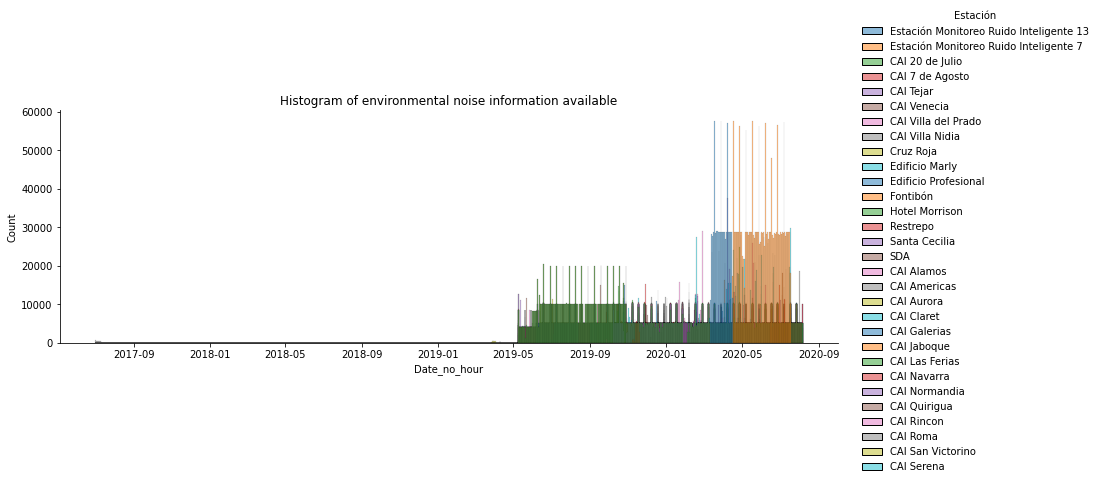

In [14]:
sns.displot(source_data_df[source_data_df['Componente']== 'Ruido']
            , x="Date_no_hour"
            , hue="Estación"
            ,height=4,aspect=3
            , palette="tab10")
plt.title("Histogram of environmental noise information available")

The available information time window runs from September 2017 to September 2020, however, it is from May 2019 that the highest concentration of environmental noise information is found. Smart noise monitoring stations have a large proportion of noise data but only for a short period of time, while the July 20 station is more constant over time.

Recalling that the Cai Villa Nidia stood out for having the lowest minimum date of the data set, we reviewed it and we noticed that our date outlier is there.

Text(0.5, 1.0, 'Histogram of environmental noise information available')

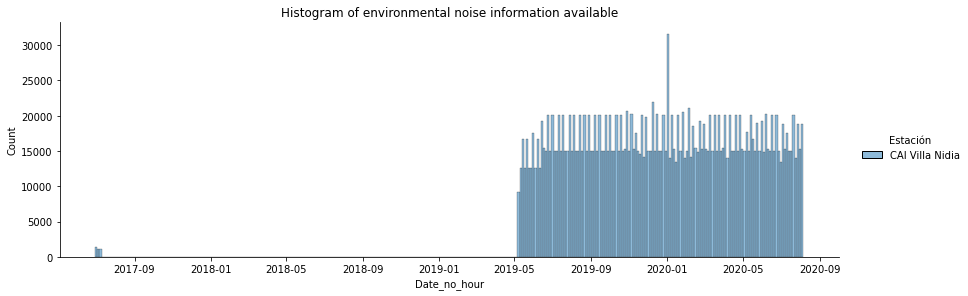

In [15]:
sns.displot(source_data_df[source_data_df['Estación']== 'CAI Villa Nidia']
            , x="Date_no_hour"
            , hue="Estación"
            ,height=4,aspect=3
            , palette="tab10")
plt.title("Histogram of environmental noise information available")

**Meteorology information available**

Text(0.5, 1.0, 'Histogram Meteorology information available')

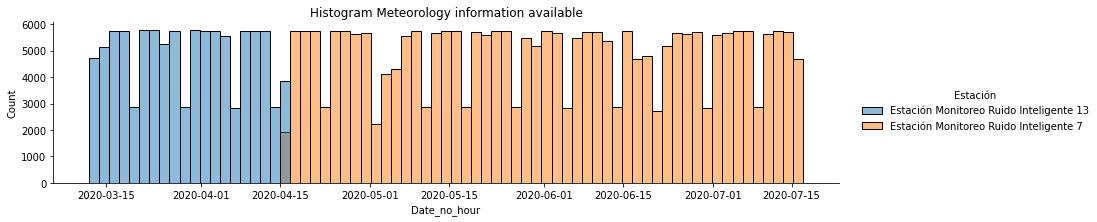

In [16]:
# Histogram Meteorology information available
sns.displot(source_data_df[source_data_df['Componente']== 'Meteorología']
            , x="Date_no_hour"
            , hue="Estación"
            ,height=3
            ,aspect=4
            , palette="tab10")

plt.title("Histogram Meteorology information available")

Only two of the stations provide us with meteorological monitoring results, one of them with records for one month (mid-March to mid-April 2020) and the other from April to July of the same year.

We generate a subset of data with the information from 4 of the stations with the highest number of records, and that have a period of similar dates in the report, we pivot the Type column `Tipo` and observe how the data behaves at the minute level for these monitoring stations.

In [6]:
# Generating sample
df_sample_noise = source_data_df[source_data_df['Estación'].isin(['CAI Venecia','CAI 20 de Julio','Edificio Marly','CAI Claret'])]
df_sample_noise.to_csv("../data/cleaned_data/df_sample_noise.csv",sep=';',header= True, encoding='utf-8',index=False)
df_sample_noise.shape

(10457683, 14)

In [7]:
# source_data_df =None
df_sample_noise = pd.read_csv("../data/cleaned_data/df_sample_noise.csv",sep=';',header= 0, encoding='utf-8')

In [8]:
# Pivot sample dataset
df_wide = df_sample_noise.pivot_table(index=['Estación', 'Componente','Variable','Fecha'
                                             , 'Year', 'Month', 'Day', 'Hour','Minuto'],columns=['Tipo'],values=['Valor'])
df_wide = df_wide.reset_index()

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


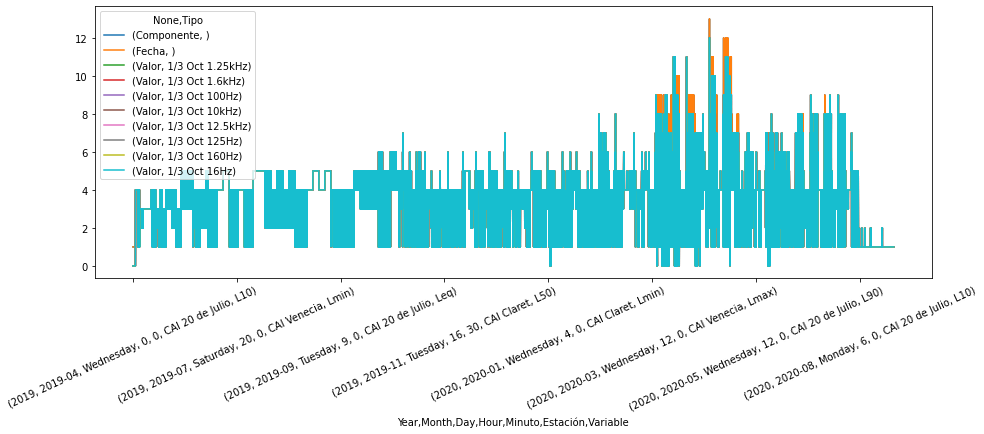

In [11]:
df_wide_group = df_wide.groupby(['Year', 'Month', 'Day', 'Hour','Minuto','Estación','Variable']).count()
df_wide_group.iloc[:,:10].plot(figsize=(15,5))
plt.xticks(rotation=25)
plt.show()

In [25]:
df_wide_group['Valor']['Leq'].sort_values(ascending =False)

Year  Month    Day        Hour  Minuto  Estación         Variable
2020  2020-05  Friday     0     0       Edificio Marly   L90         13
                                                         Lmin        13
                                                         L10         13
                                                         L50         13
                                                         Lmax        13
                                                                     ..
      2020-02  Friday     14    1       CAI Venecia      Lmin         1
                          15    0       CAI Venecia      L50          1
                                1       CAI Venecia      L10          1
                                                         L50          1
2019  2019-04  Wednesday  0     0       CAI 20 de Julio  L10          1
Name: Leq, Length: 73282, dtype: int64

In the previous graph you can see the distribution of the number of records per minute from the selected example data, we can see that per minute there may be multiple records of environmental noise, depending on the type, variable and station.

---------------------------

## Missing Values

In order to find if there are missing values, we generate an analysis at a long format level and another at a wide format.

In [17]:
# There are null fields
nullRowsDF =  source_data_df.columns[source_data_df.isnull().any()]
source_data_df[nullRowsDF].isnull().sum()

Tipo    355353
dtype: int64

In [24]:
# check cases where weight and type appear null
df_null_pt = source_data_df[(source_data_df['Ponderación'].isnull()) | (source_data_df['Tipo'].isnull())].groupby(['Componente'
                                                                                                      , 'Variable'
                                                                                                      ,'Estación'])[['Fecha']].count()
df_null_pt = df_null_pt[df_null_pt['Fecha']>0].sort_values('Fecha',ascending = False).reset_index().rename(columns={'Fecha':'nrows'})
df_null_pt

,Componente,Variable,Estación,nrows
0,Meteorología,Dirección del Viento,Estación Monitoreo Ruido Inteligente 7,"42,664.00"
1,Meteorología,Velocidad del Viento,Estación Monitoreo Ruido Inteligente 7,"42,659.00"
2,Meteorología,Presión Atmosférica,Estación Monitoreo Ruido Inteligente 7,"42,658.00"
3,Meteorología,Humedad Relativa,Estación Monitoreo Ruido Inteligente 7,"42,657.00"
4,Meteorología,Temperatura Ambiente,Estación Monitoreo Ruido Inteligente 7,"42,657.00"
5,Meteorología,Precipitación,Estación Monitoreo Ruido Inteligente 7,"42,643.00"
6,Meteorología,Humedad Relativa,Estación Monitoreo Ruido Inteligente 13,"16,570.00"
7,Meteorología,Precipitación,Estación Monitoreo Ruido Inteligente 13,"16,570.00"
8,Meteorología,Presión Atmosférica,Estación Monitoreo Ruido Inteligente 13,"16,570.00"
9,Meteorología,Temperatura Ambiente,Estación Monitoreo Ruido Inteligente 13,"16,570.00"


In the analysis of our long-format dataset, we detected that the missing values in weight and type are part of the meteorological records, and it is understandable since weight and type are exclusive properties of environmental noise measurements.

To make a more complete analysis of the missing values, we take the sample of 4 of the stations that report the highest number of records that was previously generated in wide format and using the missing library we can then visualize how the data is.

Missing data visualization


<AxesSubplot:>

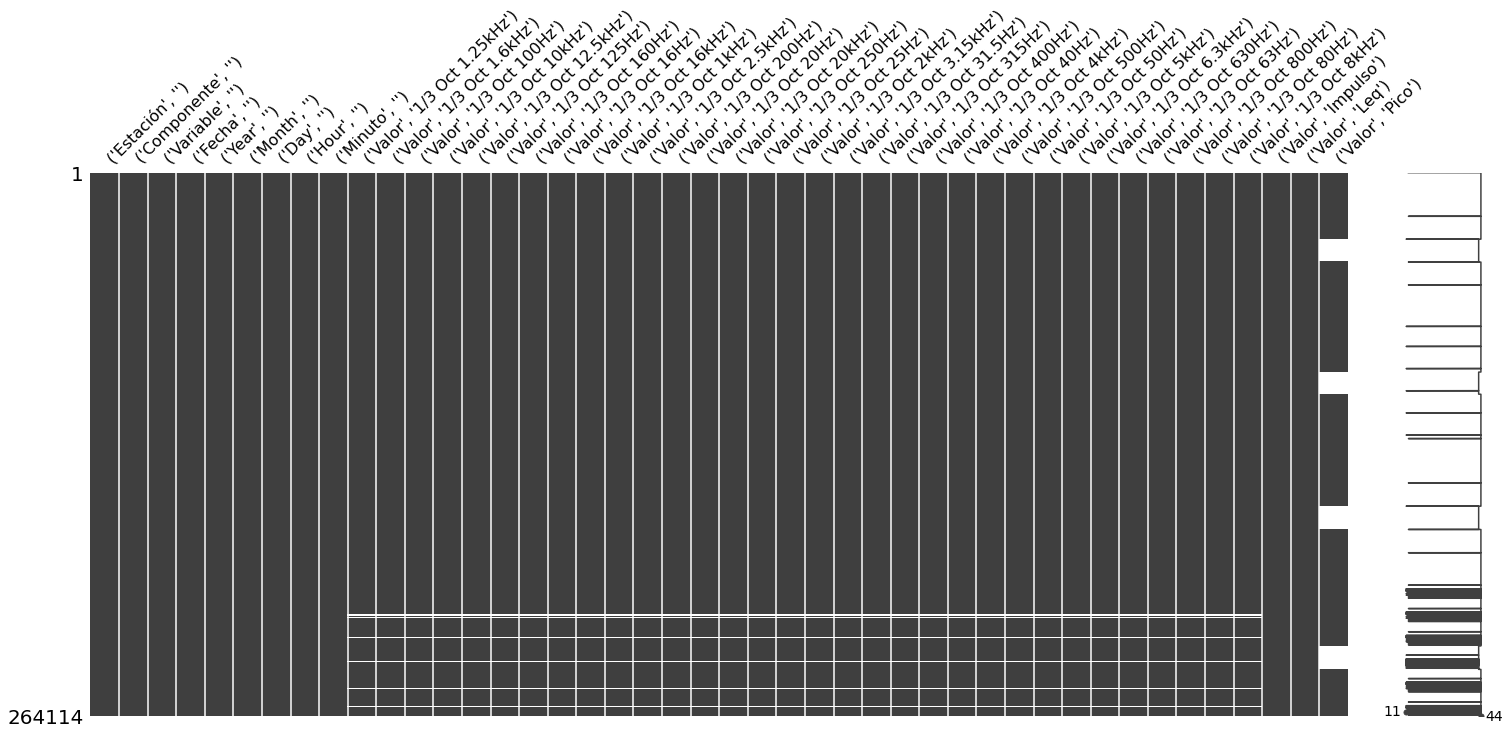

In [29]:
# Missing data visualization
print("Missing data visualization")
msno.matrix(df_wide) 

Missing data visualization - Sort


<AxesSubplot:>

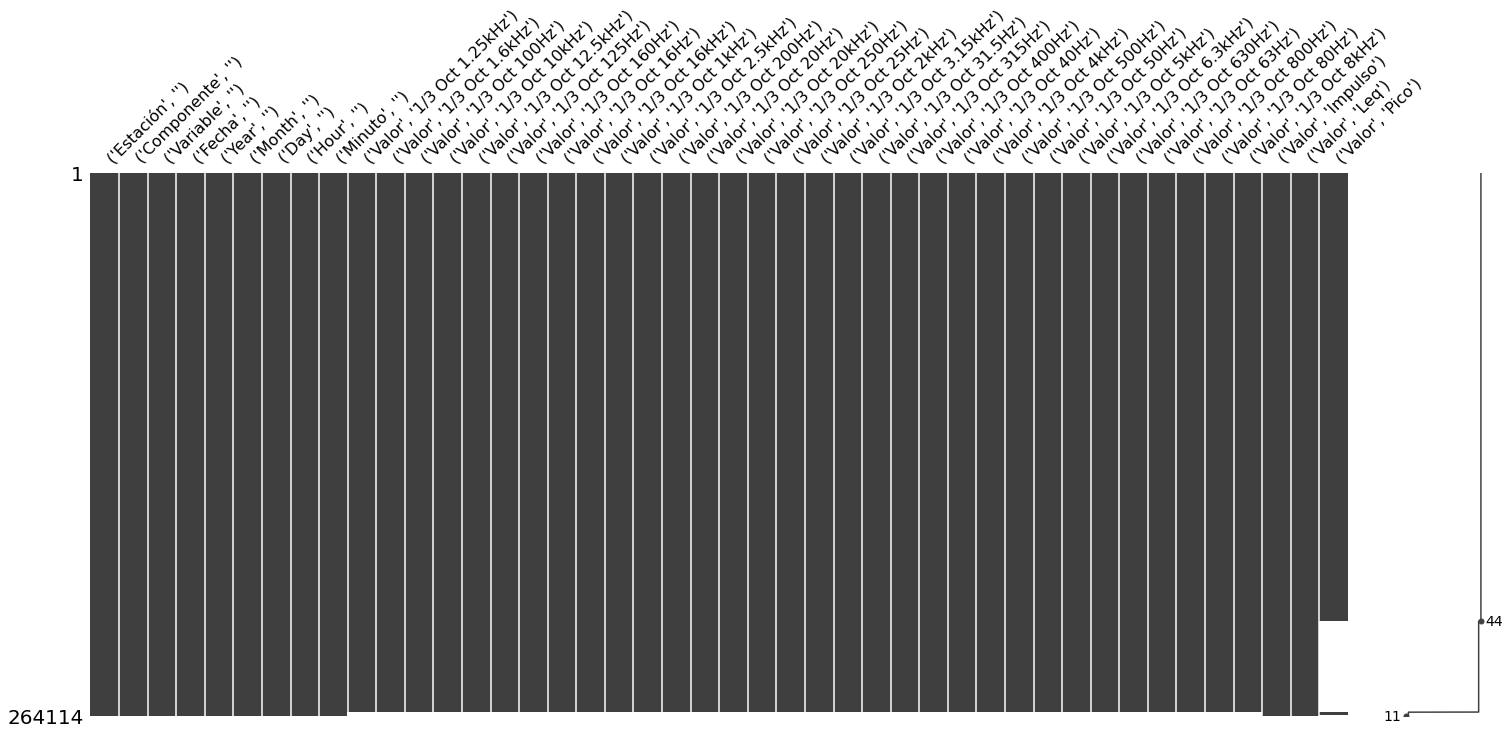

In [30]:
# Missing data visualization - Sort
sorted_data = msno.nullity_sort(df_wide, sort='descending') # or sort='ascending'
print("Missing data visualization - Sort")
msno.matrix(sorted_data)

After analyzing the previous data set we can conclude that the amount of missing values, at least for these stations, is quite low, and the type 'Leq' is that it is more complete.

***

## Cleaning 2

**Restrict information period to use**

As part of the cleaning of the data, we eliminated the records associated with dates that have very little information, these were identified as those that appear before May 1, 2019.

In [55]:
# Number of original records
length1 = len(source_data_df) 

source_data_df = source_data_df[source_data_df['Date_no_hour']>= '2019-05-01']

# Number of original records after removing duplicates 
length2=len(source_data_df) 
  
# Number of records before and after  
print('Before:', length1,' Now:', length2)
print(length2-length1)

Before: 49265878  Now: 49258804
-7074


Text(0.5, 1.0, 'Histogram of environmental noise information available')

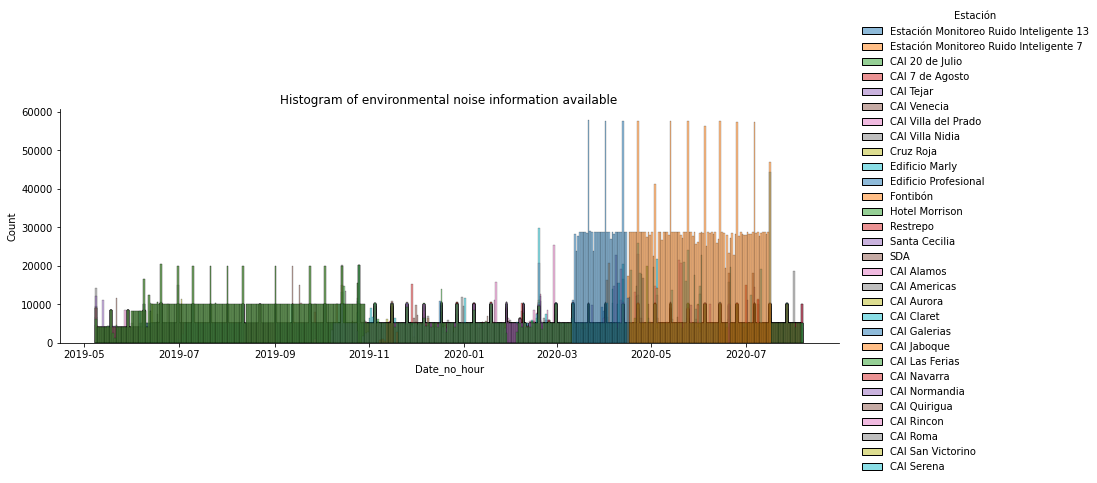

In [18]:
sns.displot(source_data_df[source_data_df['Componente']== 'Ruido']
            , x="Date_no_hour"
            , hue="Estación"
            ,height=4,aspect=3
            , palette="tab10")
plt.title("Histogram of environmental noise information available")

**Restrict information Type = `Leq`**

As we know beforehand, a large amount of our noise data contains the `Leq type`, and, currently, _this variable is used by several countries as the metric of choice to measure the exposure of workers to noise_ [1](https://www.cirrusresearch.co.uk/blog/2015/06/noise-101-what-is-equivalent-continuous-sound-level-leq/), which is why, we generate a special subset of these data to analyze later in the **EDA-Part 2**.

In [112]:
# Restrict information Type = Leq
clean_data_df = source_data_df[(source_data_df['Tipo']=='Leq') | ((source_data_df['Componente']=='Meteorología') ) ]
clean_data_df.to_csv("../data/cleaned_data/clean_data_tipo_leq.csv",sep=';',header= True, encoding='utf-8',index=False)
print(clean_data_df.shape)

(2101597, 13)


In [22]:
clean_data_df = pd.read_csv("../data/cleaned_data/clean_data_tipo_leq.csv",sep=';',header=0, encoding='utf-8',parse_dates=['Fecha','Date_no_hour'] )

Text(0.5, 1.0, 'Histogram of environmental noise information with Leq type')

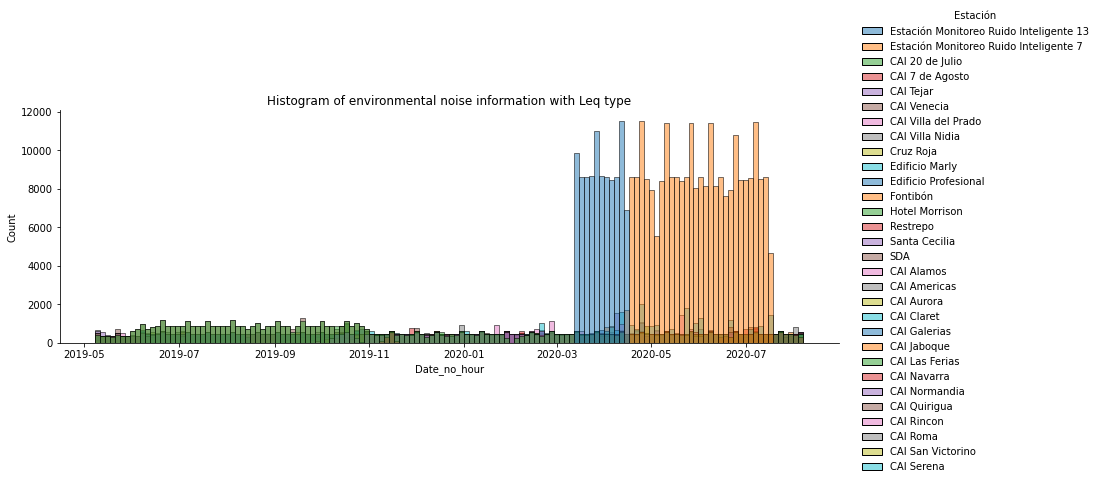

In [23]:
# Histogram of environmental noise information with Leq type
sns.displot(clean_data_df[clean_data_df['Componente']== 'Ruido']
            , x="Date_no_hour"
            , hue="Estación"
            ,height=4,aspect=3
            , palette="tab10")
plt.title("Histogram of environmental noise information with Leq type")

If we focus only on the noise data with Leq type, the stations `Estación Monitoreo Ruido Inteligente 7` and `Estación Monitoreo Ruido Inteligente 13` go from having peaks of 60000 records to a maximum of 12000. Which is a reduction of approximately 77% of the environmental noise data for these stations.

***

## Data subsets

To continue with our data exploration process, we generate subsets of information from the statistical summaries that can be seen below and that will be analyzed in more detail in **EDA-Part2**.

Basic statistical summary (mean, minimum, maximum, maximum-minimum variation and median):

- [General](#General)
- [General by hour and type](#General-by-hour-and-type)
- [By Monitoring Station and Time](#By-Monitoring-Station-and-Time)
- [By Monitoring Station, Time and Type](#By-Monitoring-Station,-Time-and-Type)
- [By Monitoring Station and Day of the week](#By-Monitoring-Station-and-Day-of-the-week)
- [By Monitoring Station and Date](#By-Monitoring-Station-and-Date)
- [By Monitoring Station, Date and Time](#By-Monitoring-Station,-Date-and-Time)


### General

In [15]:
# Create df with hourly value statistics
df_allstation_hour = pd.pivot_table(source_data_df, values=['Valor'],
                               index=['Componente','Variable','Hour'],
                               aggfunc={'Valor': [min, max, np.mean,np.median]})

df_allstation_hour.columns = ["_".join((j,k)) for j,k in df_allstation_hour.columns]
df_allstation_hour = df_allstation_hour.reset_index()

# Calculate variation between maximum and minimum value
df_allstation_hour['max-min'] = df_allstation_hour['Valor_max']-df_allstation_hour['Valor_min']


# Save summary to file
df_allstation_hour.rename(columns={'Hour':'Hora'},inplace=True)
df_allstation_hour.to_csv("../data/cleaned_data/allstation_hour.csv", sep =';', header =True, index=False, encoding='UTF-8')
df_allstation_hour.head()

,Componente,Variable,Hora,Valor_max,Valor_mean,Valor_median,Valor_min,max-min
0,Meteorología,Dirección del Viento,0,359.00,171.97,120.00,0.00,359.00
1,Meteorología,Dirección del Viento,1,358.88,175.94,150.56,0.00,358.88
2,Meteorología,Dirección del Viento,2,358.47,168.79,116.90,0.57,357.90
3,Meteorología,Dirección del Viento,3,359.00,169.74,102.55,0.00,359.00
4,Meteorología,Dirección del Viento,4,359.00,153.87,80.96,-0.04,359.04


### General by hour and type

In [14]:
# Create df with hourly value statistics
df_allstation_hour_hz = pd.pivot_table(source_data_df, values=['Valor'],
                               index=['Componente','Variable','Tipo','Hour'],
                               aggfunc={'Valor': [min, max, np.mean,np.median]})

df_allstation_hour_hz.columns = ["_".join((j,k)) for j,k in df_allstation_hour_hz.columns]
df_allstation_hour_hz = df_allstation_hour_hz.reset_index()

# Calculate variation between maximum and minimum value
df_allstation_hour_hz['max-min'] = df_allstation_hour_hz['Valor_max']-df_allstation_hour_hz['Valor_min']

# Save summary to file
df_allstation_hour_hz.rename(columns={'Hour':'Hora'},inplace=True)
df_allstation_hour_hz.to_csv("../data/cleaned_data/allstation_hour_hz.csv", sep =';', header =True, index=False, encoding='UTF-8')
df_allstation_hour_hz.head()

,Componente,Variable,Tipo,Hora,Valor_max,Valor_mean,Valor_median,Valor_min,max-min
0,Ruido,L10,1/3 Oct 1.25kHz,0,71.70,51.50,53.00,8.70,63.00
1,Ruido,L10,1/3 Oct 1.25kHz,1,73.20,49.79,51.30,8.30,64.90
2,Ruido,L10,1/3 Oct 1.25kHz,2,66.80,50.01,51.20,8.70,58.10
3,Ruido,L10,1/3 Oct 1.25kHz,3,78.30,50.60,51.50,8.70,69.60
4,Ruido,L10,1/3 Oct 1.25kHz,4,76.60,53.55,55.80,8.70,67.90


### By Monitoring Station and Time

In [7]:
# Create df with hourly value statistics
df_hour_group = pd.pivot_table(source_data_df, values=['Valor'],
                               index=['Componente','Estación','Variable','Hour'],
                               aggfunc={'Valor': [min, max, np.mean,np.median]})

df_hour_group.columns = ["_".join((j,k)) for j,k in df_hour_group.columns]
df_hour_group = df_hour_group.reset_index()

# Calculate variation between maximum and minimum value
df_hour_group['max-min'] = df_hour_group['Valor_max']-df_hour_group['Valor_min']

# Add geographic location data
df_hour_group_lat_long = df_hour_group.merge(lat_long_stations,how ='left', left_on='Estación', right_on='Estación')

# Save summary to file
df_hour_group_lat_long.rename(columns={'Hour':'Hora'},inplace=True)
df_hour_group_lat_long.to_csv("../data/cleaned_data/df_group_hora.csv", sep =';', header =True, index=False, encoding='UTF-8')
df_hour_group_lat_long.head()

,Componente,Estación,Variable,Hora,Valor_max,Valor_mean,Valor_median,Valor_min,max-min,nombre corto,latitud,longitud,altitud,altura suelo,Origen
0,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,0,359.00,201.64,248.30,0.00,359.00,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
1,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,1,358.62,194.84,253.88,0.40,358.22,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
2,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2,358.47,173.94,137.14,0.68,357.79,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
3,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,3,359.00,161.55,75.64,0.00,359.00,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
4,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,4,359.00,171.59,108.20,0.34,358.66,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil


### By Monitoring Station, Time and Type

In [13]:
# Create df By Monitoring Station, Time and Type
df_hour_group_hz = pd.pivot_table(source_data_df, values=['Valor'],
                               index=['Componente','Estación','Variable','Tipo','Hour'],
                               aggfunc={'Valor': [min, max, np.mean,np.median]})

df_hour_group_hz.columns = ["_".join((j,k)) for j,k in df_hour_group_hz.columns]
df_hour_group_hz = df_hour_group_hz.reset_index()

# Calculate variation between maximum and minimum value
df_hour_group_hz['max-min'] = df_hour_group_hz['Valor_max']-df_hour_group_hz['Valor_min']

# Add geographic location data
df_hour_group_hz_lat_long = df_hour_group_hz.merge(lat_long_stations,how ='left', left_on='Estación', right_on='Estación')

# Save summary to file
df_hour_group_hz_lat_long.rename(columns={'Hour':'Hora'},inplace=True)
df_hour_group_hz_lat_long.to_csv("../data/cleaned_data/df_group_hora_hz.csv", sep =';', header =True, index=False, encoding='UTF-8')
df_hour_group_hz_lat_long.head()

,Componente,Estación,Variable,Tipo,Hora,Valor_max,Valor_mean,Valor_median,Valor_min,max-min,nombre corto,latitud,longitud,altitud,altura suelo,Origen
0,Ruido,CAI 20 de Julio,L10,1/3 Oct 1.25kHz,0,69.50,50.44,50.50,38.50,31.00,CAI20JUL,4.57,-74.09,nan,nan,SDA
1,Ruido,CAI 20 de Julio,L10,1/3 Oct 1.25kHz,1,61.70,48.28,48.90,27.60,34.10,CAI20JUL,4.57,-74.09,nan,nan,SDA
2,Ruido,CAI 20 de Julio,L10,1/3 Oct 1.25kHz,2,61.00,47.94,48.00,33.90,27.10,CAI20JUL,4.57,-74.09,nan,nan,SDA
3,Ruido,CAI 20 de Julio,L10,1/3 Oct 1.25kHz,3,68.50,47.53,47.70,33.70,34.80,CAI20JUL,4.57,-74.09,nan,nan,SDA
4,Ruido,CAI 20 de Julio,L10,1/3 Oct 1.25kHz,4,64.80,51.28,50.70,39.90,24.90,CAI20JUL,4.57,-74.09,nan,nan,SDA


### By Monitoring Station and Day of the week

In [8]:
# Create df with statistics by day of the week
df_day_group = pd.pivot_table(source_data_df, values=['Valor'],
                               index=['Componente','Estación','Variable','Day'],
                               aggfunc={'Valor': [min, max, np.mean,np.median]})

df_day_group.columns = ["_".join((j,k)) for j,k in df_day_group.columns]
df_day_group = df_day_group.reset_index()

# Calculate variation between maximum and minimum value
df_day_group['max-min'] = df_day_group['Valor_max']-df_day_group['Valor_min']

# Add geographic location data
df_day_group_lat_long = df_day_group.merge(lat_long_stations,how ='left', left_on='Estación', right_on='Estación')

# Save summary to file
df_day_group_lat_long.rename(columns={'Day':'Dia'},inplace=True)
df_day_group_lat_long.to_csv("../data/cleaned_data/df_group_dia.csv", sep =';', header =True, index=False, encoding='UTF-8')
df_day_group_lat_long.head(2)

,Componente,Estación,Variable,Dia,Valor_max,Valor_mean,Valor_median,Valor_min,max-min,nombre corto,latitud,longitud,altitud,altura suelo,Origen
0,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,Friday,358.59,209.04,271.12,-43.97,402.56,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
1,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,Saturday,359.00,192.70,243.49,0.00,359.00,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil


### By Monitoring Station and Date

In [9]:
# Create df with statistics by date of the week
df_date_group = pd.pivot_table(source_data_df, values=['Valor'],
                               index=['Componente','Estación','Variable','Date_no_hour'],
                               aggfunc={'Valor': [min, max, np.mean,np.median]})

df_date_group.columns = ["_".join((j,k)) for j,k in df_date_group.columns]
df_date_group = df_date_group.reset_index()

# Calculate variation between maximum and minimum value
df_date_group['max-min'] = df_date_group['Valor_max']-df_date_group['Valor_min']

# Add geographic location data
df_date_group_lat_long = df_date_group.merge(lat_long_stations,how ='left', left_on='Estación', right_on='Estación')

# Save summary to file
# df_date_group_lat_long.rename(columns={'Date_no_hour':'Fecha_Dia'},inplace=True)
df_date_group_lat_long.to_csv("../data/cleaned_data/df_group_fecha.csv", sep =';', header =True, index=False, encoding='UTF-8')
df_date_group_lat_long.head()

,Componente,Estación,Variable,Date_no_hour,Valor_max,Valor_mean,Valor_median,Valor_min,max-min,nombre corto,latitud,longitud,altitud,altura suelo,Origen
0,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-12,354.19,210.89,259.00,7.91,346.28,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
1,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-13,358.40,246.60,278.81,0.73,357.67,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
2,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-14,357.71,223.65,253.58,2.63,355.08,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
3,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-15,358.65,195.46,257.62,0.00,358.65,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
4,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-16,356.75,206.70,274.18,0.94,355.81,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil


### By Monitoring Station, Date and Time

In [11]:
# Create df with statistics by date of the week
df_date_hour_group = pd.pivot_table(source_data_df, values=['Valor'],
                               index=['Componente','Estación','Variable','Date_no_hour','Hour'],
                               aggfunc={'Valor': [min, max, np.mean,np.median]})

df_date_hour_group.columns = ["_".join((j,k)) for j,k in df_date_hour_group.columns]
df_date_hour_group = df_date_hour_group.reset_index()

# Calculate variation between maximum and minimum value
df_date_hour_group['max-min'] = df_date_hour_group['Valor_max']-df_date_hour_group['Valor_min']

# Agregar datos de ubicación geografica
df_date_hour_group_lat_long = df_date_hour_group.merge(lat_long_stations,how ='left', left_on='Estación', right_on='Estación')

# Save summary to file
df_date_hour_group_lat_long.rename(columns={'Hour':'Hora'},inplace=True)
df_date_hour_group_lat_long.to_csv("../data/cleaned_data/df_group_fecha_hora.csv", sep =';', header =True, index=False, encoding='UTF-8')
df_date_hour_group_lat_long.head()

,Componente,Estación,Variable,Date_no_hour,Hora,Valor_max,Valor_mean,Valor_median,Valor_min,max-min,nombre corto,latitud,longitud,altitud,altura suelo,Origen
0,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-12,15,266.00,264.34,265.37,260.93,5.07,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
1,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-12,16,268.00,261.43,261.75,256.23,11.77,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
2,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-12,17,264.30,258.18,257.23,255.00,9.30,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
3,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-12,18,281.64,268.11,265.07,261.60,20.04,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
4,Meteorología,Estación Monitoreo Ruido Inteligente 13,Dirección del Viento,2020-03-12,19,291.30,281.09,286.03,253.76,37.55,EMRI 13,4.70,-74.14,0.00,0.00,aerocivil
